In [45]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Input
from keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
# UTKFace dataset
path = '/kaggle/input/utkface-new/UTKFace/'

x = [] # Normalized input
y = [] # Output (age)

for file in os.listdir(path):
    if file.endswith(('.jpg', '.png', '.jpeg')):
            age = int(file.split('_')[0])

            # Resize to 128, 128 and flatten
            image = Image.open(os.path.join(path, file))
            image = image.convert('RGB')
            image = image.resize((128, 128))
            x.append(np.array(image))

            # Append age label
            y.append(age)

# Normalize
x = np.array(x, dtype=np.float32) / 255.0
y = np.array(y, dtype=np.int32)

In [47]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [48]:
# nnmodel = Sequential()

# # Block 1
# nnmodel.add(Conv2D(32, (3,3), padding='same', input_shape=(128,128,3)))
# nnmodel.add(MaxPooling2D((2,2)))

# # Block 2
# nnmodel.add(Conv2D(64, (3,3), padding='same'))
# nnmodel.add(MaxPooling2D((2,2)))

# # Block 3
# nnmodel.add(Conv2D(128, (3,3), padding='same'))
# nnmodel.add(MaxPooling2D((2,2)))

# # Fully Connected Layers
# nnmodel.add(Flatten())
# nnmodel.add(Dense(256, kernel_regularizer=l2(0.001)))
# nnmodel.add(LeakyReLU(alpha=0.1))
# nnmodel.add(Dropout(0.2))
# nnmodel.add(Dense(128, kernel_regularizer=l2(0.001)))
# nnmodel.add(LeakyReLU(alpha=0.1))
# nnmodel.add(Dropout(0.2))
# #nnmodel.add(Dense(99, activation='softmax'))
# nnmodel.add(Dense(1, activation='linear'))

# nnmodel.compile(optimizer='adam', loss='mse', metrics=['mae', 'r2_score'])  # MAE (Mean Absolute Error) is good for age prediction
# nnmodel.summary()

In [49]:
# Using MobileNetV2
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers

nnmodel = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Averaging all channels
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='linear')  # Regression output
])

nnmodel.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae', 'r2_score'])
nnmodel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [50]:
trained = nnmodel.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 18.1701 - mae: 18.1701 - r2_score: -0.4902 - val_loss: 11.4053 - val_mae: 11.4053 - val_r2_score: 0.4071
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 11.2818 - mae: 11.2818 - r2_score: 0.4197 - val_loss: 10.3839 - val_mae: 10.3839 - val_r2_score: 0.5186
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 10.6869 - mae: 10.6869 - r2_score: 0.4950 - val_loss: 9.9827 - val_mae: 9.9827 - val_r2_score: 0.5521
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 10.3806 - mae: 10.3806 - r2_score: 0.5260 - val_loss: 9.7633 - val_mae: 9.7633 - val_r2_score: 0.5642
Epoch 5/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 10.0362 - mae: 10.0362 - r2_score: 0.5502 - val_loss: 9.5140 - val_mae: 9.5140 - val_r2_score: 0.5828
Epoch 6/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 9.7277 - mae: 9.7277 - r2_score: 0.5669 - val_loss: 9.3345 - val_mae: 9.3345 - val_r2_score: 0.5926
Epoch 7/100


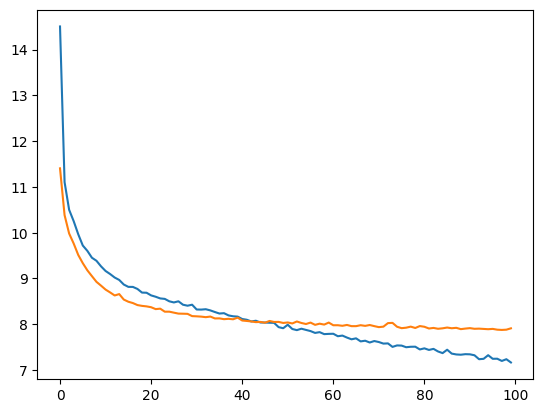

In [51]:
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])

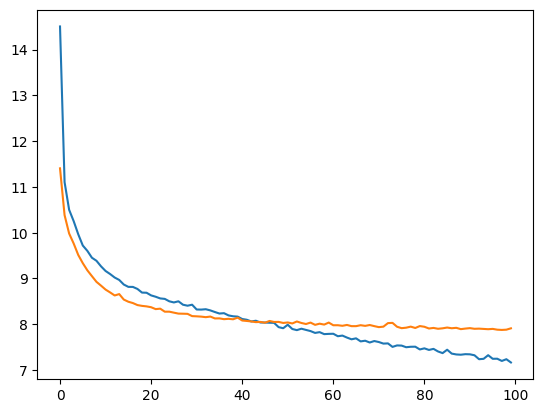

In [52]:
plt.plot(trained.history['mae'])
plt.plot(trained.history['val_mae'])

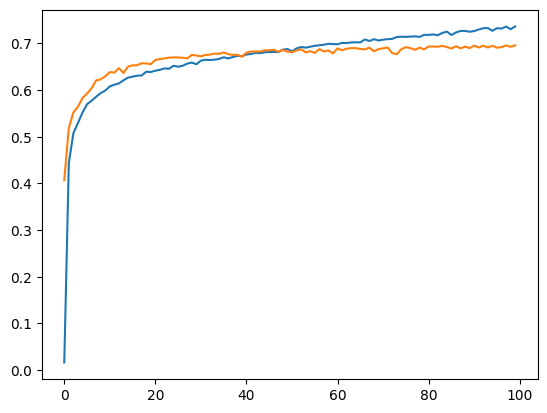

In [53]:
plt.plot(trained.history['r2_score'])
plt.plot(trained.history['val_r2_score'])

In [54]:
# Morsi's image
image = Image.open("/kaggle/input/testtest/Screenshot_2.png")

# Resize to CNN input size (e.g., 128x128)
image = image.resize((128, 128))

# Convert to NumPy array
image_array = np.array(image)

# Normalize pixel values (0 to 1)
image_array = image_array.astype('float32') / 255.0
image_array = image_array[:, :, :3]  # Remove alpha channel

# Ensure the image has the correct shape before adding the batch dimension
image_array = image_array.reshape(128, 128, 3)  # Force shape correction

# Add the batch dimension
image_array = np.expand_dims(image_array, axis=0)

print(image_array.shape)  # Should be (1, 128, 128, 3)
print(nnmodel.predict(image_array))

(1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[23.175646]]


In [55]:
nnmodel.save('/kaggle/working/age.h5')